In [1]:
import requests
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import os 
import numpy as np

from dotenv import load_dotenv

# Pulling S&P 500 Data

In [2]:
load_dotenv()
AV_API_KEY = os.getenv('AV_API_KEY')
BASE_URL = 'https://www.alphavantage.co/query?'
TICKER = 'SPY'

In [3]:
params = {
    "function": "TIME_SERIES_DAILY_ADJUSTED",
    "symbol": TICKER,
    "outputsize":"full",
    "apikey": AV_API_KEY
}

resp = requests.get(BASE_URL,params=params)

In [4]:
ts = resp.json()['Time Series (Daily)']

In [5]:
close_ts = {datetime.strptime(tick, '%Y-%m-%d'):float(ts[tick]['5. adjusted close']) for tick in ts}

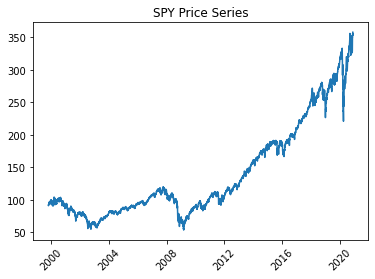

In [6]:
fig = sns.lineplot(x = close_ts.keys(),y = close_ts.values())
fig.set_title(f"{TICKER} Price Series")
plt.xticks(rotation=45)
plt.show()

In [7]:
price = pd.DataFrame.from_dict(close_ts,orient='index',columns=['SPY'])

In [8]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

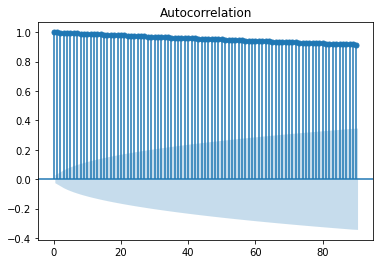

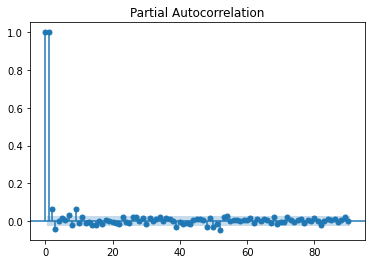

In [9]:
plot_acf(price[TICKER].to_numpy(),missing="drop",lags=90,fft=False)
plot_pacf(price[TICKER].to_numpy(),lags=90)
plt.show()

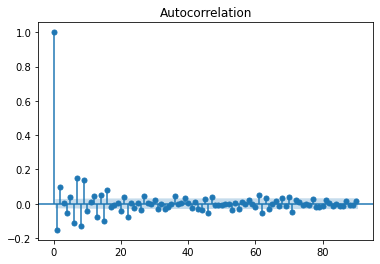

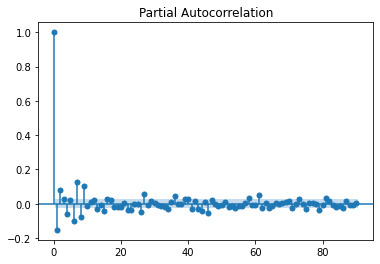

In [10]:
plot_acf(price[TICKER].diff(periods=-1).dropna().to_numpy(),missing="drop",lags=90,fft=False)
plot_pacf(price[TICKER].diff(periods=-1).dropna().to_numpy(),lags=90)
plt.show()

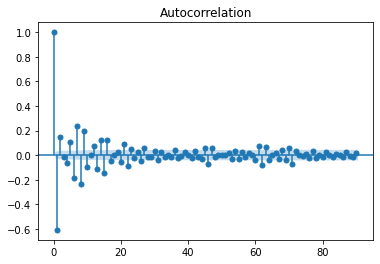

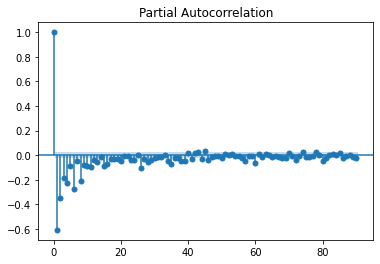

In [11]:
plot_acf(price[TICKER].diff(periods=-1).diff(periods=-1).dropna().to_numpy(),missing="drop",lags=90,fft=False)
plot_pacf(price[TICKER].diff(periods=-1).diff(periods=-1).dropna().to_numpy(),lags=90)
plt.show()

# Reversal Backtest

In [73]:
initial = 1000
price = price.sort_index().dropna()
price['daily_return'] = price.pct_change(1) + 1

In [89]:
def reversal_trade(r):
    if r <= 0.91:
        return 'BUY'
    elif r >= 1.01:
        return 'SELL'
    else:
        return 'HOLD'

In [90]:
price['trade'] = price.daily_return.apply(lambda r: reversal_trade(r))
price['next_day_return'] = price.daily_return.shift(-1)

In [91]:
price.head()

,SPY,daily_return,trade,next_day_return
1999-11-02,90.9450,NaN,HOLD,1.006734
1999-11-03,91.5574,1.006734,HOLD,1.007611
1999-11-04,92.2542,1.007611,HOLD,1.009842
1999-11-05,93.1622,1.009842,HOLD,1.000907
1999-11-08,93.2467,1.000907,HOLD,0.990601


In [92]:
import numpy as np
np.product(price.next_day_return)

3.921820880752137

In [93]:
np.product(price.loc[price.trade != 'SELL'].next_day_return)

8.72667917787097

In [94]:
price.loc[price.trade == 'SELL']

,SPY,daily_return,trade,next_day_return
1999-12-03,97.1952,1.018362,SELL,0.992614
1999-12-21,97.4109,1.015222,SELL,1.002608
1999-12-23,99.2206,1.015929,SELL,0.998613
2000-01-07,98.7232,1.058077,SELL,1.003431
2000-01-13,98.2152,1.013543,SELL,1.013577
...,...,...,...,...
2020-11-02,330.2000,1.011208,SELL,1.017656
2020-11-03,336.0300,1.017656,SELL,1.022349
2020-11-04,343.5400,1.022349,SELL,1.019503
2020-11-05,350.2400,1.019503,SELL,0.999772


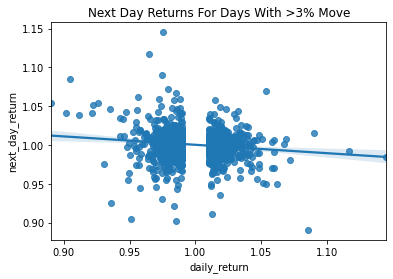

In [95]:
sub = price.loc[(price.daily_return > 1.01) | (price.daily_return < 0.99)]
fig = sns.regplot(x=sub.daily_return,y=sub.next_day_return)
fig.set_title('Next Day Returns For Days With >3% Move')
plt.show()

In [96]:
sub.corr()[['daily_return','next_day_return']]

,daily_return,next_day_return
SPY,0.028250,-0.031084
daily_return,1.000000,-0.138501
next_day_return,-0.138501,1.000000


In [101]:
capital = 10000
invested = 90000
buys = 0
sells = 0

for index, row in price.dropna().iterrows():
    if row['trade'] == 'BUY':
        
        if (capital > 0) & (invested != 0):    
            
            amt = capital*0.20
            invested += amt
            capital -= amt
            buys += 1
        
        elif invested == 0:
            
            amt = capital*0.95
            invested += amt
            capital -= amt
            
        invested = invested*row['next_day_return']
        
    else:
        
        invested = invested*row['next_day_return']
        
    

In [102]:
invested

754560.4116884255

In [103]:
capital

5120.0

In [100]:
buys

3

In [221]:
sells

0

In [229]:
invested = 100000

for index, row in price.dropna().iterrows():
  
    invested = invested*row['next_day_return']

In [230]:
invested

386686.38471603644

# LSTM

Following along [here](https://towardsdatascience.com/time-series-of-price-anomaly-detection-with-lstm-11a12ba4f6d9)

In [333]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from plotly import graph_objects as go
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [334]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=price.index, y=price[TICKER], name=f"{TICKER}"))
fig.update_layout(showlegend=True, title=f"{TICKER} Time Series {min(price.index.date)} to {max(price.index.date)}")
fig.show()

In [335]:
#New monetary regime
sub = price.loc[price.index >= '2009-01-01']
train, test = sub.loc[sub.index <= '2019-1-01'], sub.loc[sub.index > '2019-01-01']

In [336]:
scaler = StandardScaler()
scaler = scaler.fit(train[[TICKER]])

train[TICKER] = scaler.transform(train[[TICKER]])
test[TICKER] = scaler.transform(test[[TICKER]])

<ipython-input-336-86c178f15f36>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-336-86c178f15f36>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [337]:
TIME_STEPS=90

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[[TICKER]], train[TICKER])
X_test, y_test = create_sequences(test[[TICKER]], test[TICKER])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (2426, 90, 1)
Testing shape: (383, 90, 1)


In [338]:
model = Sequential()
model.add(LSTM(512, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 512)               1052672   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 90, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 90, 512)           2099200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 512)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 90, 1)             513       
Total params: 3,152,385
Trainable params: 3,152,385
Non-trainable params: 0
____________________________________________

In [339]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
69/69 [==============================] - 62s 892ms/step - loss: 0.1330 - val_loss: 0.0683
Epoch 2/100
69/69 [==============================] - 65s 946ms/step - loss: 0.1360 - val_loss: 0.0833
Epoch 3/100
69/69 [==============================] - 72s 1s/step - loss: 0.0566 - val_loss: 0.0781
Epoch 4/100
69/69 [==============================] - 77s 1s/step - loss: 0.1020 - val_loss: 0.0688


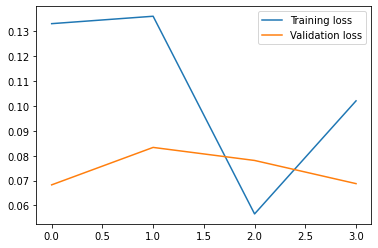

In [340]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [341]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 3s 254ms/step - loss: 0.9016


0.9015845656394958

Reconstruction error threshold: 0.8742258541968613


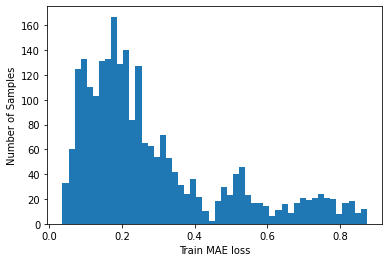

In [342]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

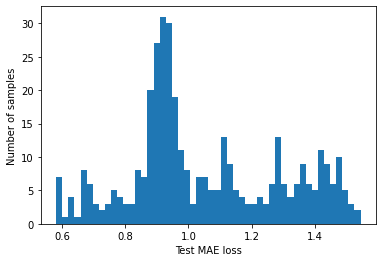

In [343]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [344]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df[TICKER] = test[TIME_STEPS:][TICKER]

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df.index.date, y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df.index.date, y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [345]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(314, 4)

In [346]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df.index.date, y=scaler.inverse_transform(test_score_df[TICKER]), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies.index.date, y=scaler.inverse_transform(anomalies[TICKER]), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

# Spectral Decomposition

In [227]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.decomposition import SingularSpectrumAnalysis

In [228]:
X = sub.copy()
X['yest']= X[TICKER].shift(-1)
X['logret'] = np.log10(X[TICKER]/X['yest'])

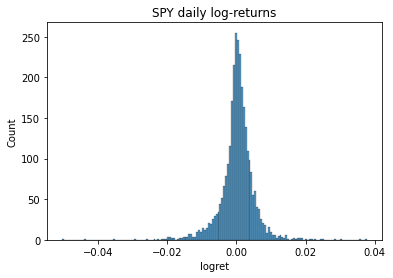

In [230]:
fig = sns.histplot(X.logret)
fig.set_title(f"{TICKER} daily log-returns")
plt.show()

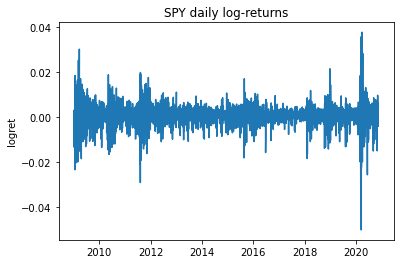

In [250]:
fig = sns.lineplot(x=X.index,y=X.logret)
fig.set_title(f"{TICKER} daily log-returns")
plt.show()

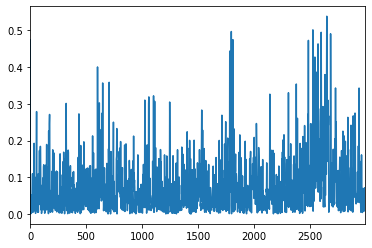

In [355]:
from scipy import fftpack

s = X.logret.dropna().to_numpy()
ps = np.abs(np.fft.fft(s))**2

time_step = 1/(len(s))
freqs = np.fft.fftfreq(s.size, time_step)
idx = np.argsort(freqs)

plt.plot(freqs[idx], ps[idx])
plt.xlim(0,len(s))
plt.show()

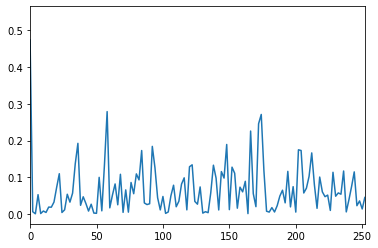

In [358]:
plt.plot(freqs[idx], ps[idx])
plt.xlim(0,252)
plt.show()

# Auto-ARIMA

In [12]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs

In [13]:
price = price.sort_index(ascending=True)

In [14]:
# Estimate the number of differences using an ADF test:
n_adf = ndiffs(price, test='adf')  # -> 0

# Or a KPSS test (auto_arima default):
n_kpss = ndiffs(price, test='kpss')  # -> 0

# Or a PP test:
n_pp = ndiffs(price, test='pp')  # -> 0

In [15]:
fit = pm.auto_arima(price, start_p=15, start_q=1,
                             max_p=15, start_d=2, max_d=2, max_q=1, seasonal=False,trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True) 

Performing stepwise search to minimize aic
 ARIMA(15,2,1)(0,0,0)[0] intercept   : AIC=21183.504, Time=38.47 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=25931.051, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=23486.885, Time=0.24 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.29 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=25929.051, Time=0.07 sec
 ARIMA(14,2,1)(0,0,0)[0] intercept   : AIC=21194.349, Time=31.69 sec
 ARIMA(15,2,0)(0,0,0)[0] intercept   : AIC=21430.028, Time=7.66 sec
 ARIMA(14,2,0)(0,0,0)[0] intercept   : AIC=21473.583, Time=4.85 sec
 ARIMA(15,2,1)(0,0,0)[0]             : AIC=inf, Time=17.99 sec

Best model:  ARIMA(15,2,1)(0,0,0)[0] intercept
Total fit time: 103.365 seconds


In [16]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5291
Model:              SARIMAX(15, 2, 1)   Log Likelihood              -10573.752
Date:                Mon, 09 Nov 2020   AIC                          21183.504
Time:                        22:26:54   BIC                          21301.825
Sample:                             0   HQIC                         21224.855
                               - 5291                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9.544e-05      0.001      0.168      0.867      -0.001       0.001
ar.L1         -0.1160      0.005    -21.344      0.000      -0.127      -0.105
ar.L2          0.0529      0.006      9.565      0.000       0.042       0.064
ar.L3          0.0293      0.006      4.824      0.000       0.017       0.041
ar.L4         -0.0625      0.006    -10.024      0.000      -0.075      -0.050
ar.L5         -0.0063      0.006     -1.029      0.303      -0.018       0.006
ar.L6         -0.0806      0.006    -12.705      0.000      -0.093      -0.068
ar.L7          0.0950      0.007     13.775      0.000       0.081       0.109
ar.L8         -0.0736      0.006    -12.947      0.000      -0.085      -0.062
ar.L9          0.0870      0.007     12.263      0.000       0.073       0.101
ar.L10        -0.0178      0.006     -2.890      0.004      -0.030      -0.006
ar.L11         0.0018      0.007      0.252      0.801      -0.012       0.016
ar.L12         0.0173      0.007      2.326      0.020       0.003       0.032
ar.L13        -0.0376      0.008     -4.973      0.000      -0.052      -0.023
ar.L14        -0.0178      0.008     -2.356      0.018      -0.033      -0.003
ar.L15        -0.0516      0.007     -6.904      0.000      -0.066      -0.037
ma.L1         -0.9803      0.003   -387.466      0.000      -0.985      -0.975
sigma2         3.1827      0.021    153.361      0.000       3.142       3.223
===================================================================================
Ljung-Box (Q):                       95.19   Jarque-Bera (JB):            158055.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.41   Skew:                            -1.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

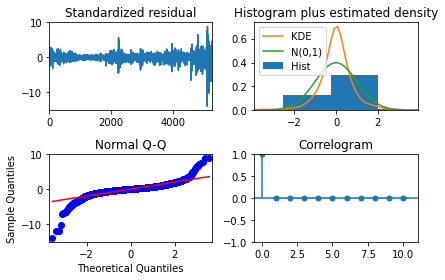

In [17]:
fig = fit.plot_diagnostics()
plt.tight_layout()
plt.show()

Average daily pct change -0.00017714645134760755
Median daily pct change -0.0006948791055709225


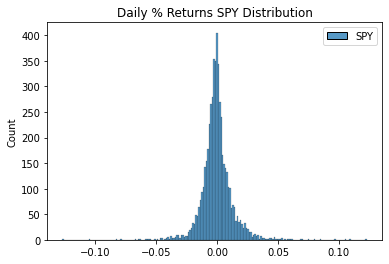

In [18]:
fig = sns.histplot(price.pct_change(-1))
print(f"Average daily pct change {price.pct_change(-1).mean()[0]}")
print(f"Median daily pct change {price.pct_change(-1).median()[0]}")
fig.set_title('Daily % Returns SPY Distribution')
plt.show()

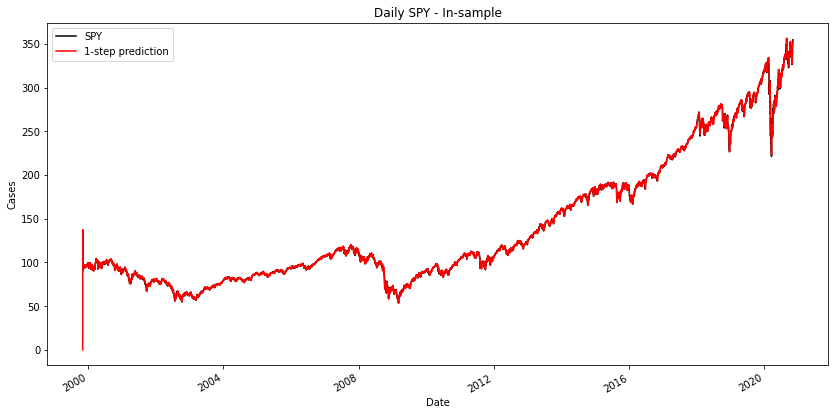

In [19]:
in_sample = fit.predict_in_sample()
pred = pd.DataFrame(in_sample,index=price.index,columns=['1-step prediction'])

ax = price.plot(label='observed', figsize=(14, 7),color='black')
pred.plot(ax=ax, label='forecast',color='red')

ax.set_xlabel('Date')
ax.set_ylabel('Cases')
ax.set_title(f"Daily {TICKER} - In-sample")
plt.legend()
plt.show()

In [20]:
steps= 7
future_index = pd.date_range(start=pd.datetime.now().date(),periods=steps,freq='B')
pred_future = pd.DataFrame(fit.predict(n_periods=steps,return_conf_int=False),index=future_index)
pred_future.columns =['predicted']

<ipython-input-20-ddc99777d63e>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  future_index = pd.date_range(start=pd.datetime.now().date(),periods=steps,freq='B')


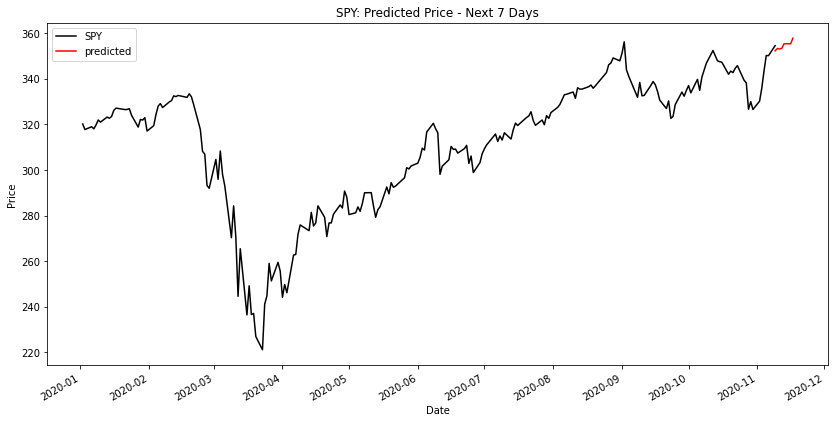

In [21]:
ax = price.loc['2020-01-01':'2020-11-09'].plot(label='observed', figsize=(14, 7),color='black')
pred_future.plot(ax=ax, label='forecast',color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title(f"{TICKER}: Predicted Price - Next {steps} Days")
plt.legend()
plt.show()

In [22]:
print(f"1 step-ahead forecast for {TICKER}: ${fit.predict(n_periods=1)[0].round(2)}")

1 step-ahead forecast for SPY: $352.29


In [43]:
price['dow'] = price.index.isocalendar().day
price['pct_change'] = price[TICKER].pct_change(-1)
price.groupby('dow').std()['pct_change']

dow
1    0.012495
2    0.012196
3    0.012482
4    0.011331
5    0.014161
Name: pct_change, dtype: float64

Fridays tend to be more volatile